In [338]:
import numpy as np
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import inv


In [339]:
def create_1d_laplacian(n):
    """Creates a 1D Laplacian matrix of size n x n."""
    e = np.ones(n)
    diagonals = [-2 * e, e, e]
    laplacian_1d = diags(diagonals, [0, -1, 1], shape=(n, n))
    return laplacian_1d

def create_2d_laplacian(n,h):
    """Creates a sparse 2D Laplacian matrix using Kronecker product."""
    laplacian_1d = create_1d_laplacian(n)
    identity = eye(n)
    
    # Use Kronecker product to create the 2D Laplacian
    laplacian_2d = kron(laplacian_1d, identity) + kron(identity, laplacian_1d)
    return laplacian_2d

In [340]:
def create_1d_laplacian_with_edges(n, h):
    """
    Creates a 1D Laplacian matrix of size n x n, incorporating one-sided 
    finite differences for edge points.
    """
    # Central difference for the interior points
    e = np.ones(n)
    diagonals = [-2 * e, e, e]
    laplacian_1d = diags(diagonals, [0, -1, 1], shape=(n, n)) 

    # One-sided difference for the edge points
    laplacian_1d = laplacian_1d.toarray()  # Convert to dense for easy modification

    # Left edge (forward difference)
    laplacian_1d[0, 0] = -2    # / h**2
    laplacian_1d[0, 1] = 5     # / h**2
    laplacian_1d[0, 2] = -4    # / h**2
    laplacian_1d[0, 3] = 1     # / h**2
#
    # Right edge (backward diff#erence)
    laplacian_1d[n-1, n-1] = -2# / h**2
    laplacian_1d[n-1, n-2] = 5 # / h**2
    laplacian_1d[n-1, n-3] = -4# / h**2
    laplacian_1d[n-1, n-4] = 1 # / h**2

    return laplacian_1d

def create_2d_laplacian_with_edges(n, h):
    """
    Creates a sparse 2D Laplacian matrix using Kronecker product and includes 
    one-sided finite differences for the edge points.
    """
    laplacian_1d_with_edges = create_1d_laplacian_with_edges(n, h)
    identity = eye(n)
    
    # Use Kronecker product to create the 2D Laplacian
    laplacian_2d = kron(laplacian_1d_with_edges, identity) + kron(identity, laplacian_1d_with_edges)
    
    return laplacian_2d/h**2

In [341]:
N = 32
x = np.linspace(0,2*np.pi,N)
y = np.linspace(0,2*np.pi,N)
h = x[1]-x[0]
X,Y = np.meshgrid(x,y)

Lap = create_2d_laplacian_with_edges(N,h)
u = lambda x,y,t: np.cos(10*t)*np.sin(x)*np.sin(y)
f = lambda x,y,t: -10*np.sin(10*t)*np.sin(x)*np.sin(y) + 2*np.cos(10*t)*np.sin(x)*np.sin(y)

F = f(X,Y,X*0)
U = u(X,Y,X*0)
u_exact = u(X,Y,X*0 + np.pi*2)
u_exact = u_exact.reshape((-1,1)).flatten()
U=U.reshape((-1,1)).flatten()
F=F.reshape((-1,1)).flatten()
X=X.reshape((-1,1)).flatten()
Y=Y.reshape((-1,1)).flatten()
Lap @ U

array([0.00000000e+00, 1.65326695e-03, 3.23884896e-03, ...,
       3.23884896e-03, 1.65326695e-03, 4.02321503e-18])

In [342]:
def forward_euler_step(u,lap,ft,t,step):
    F = ft(t)
    dudt = (lap @ u) + F
    return u + dudt*step

In [343]:
def backward_euler_step(u,lap,ft,t,step):
    return spsolve((eye(len(u)) - step*lap), (u + step*ft(t+step)))


In [344]:
def crank_nicolson_step(u,lap,ft,t,step):
    return  spsolve((eye(len(u)) - step/2*lap), (u+ step/2*(ft(t+step) + lap @ u + ft(t))))


In [345]:
def midpoint_step(u,lap,ft,t,step):
    # u_star = forward_euler_step(u,lap,ft,t,step/2)
    F = ft(t)
    dudt = (lap @ u) + F
    u_star = u + step/2*dudt
    F_adj = ft(t+step/2)
    dudt_adj = (lap @ u_star) + F_adj
    return u + step*dudt_adj
    

In [346]:
def run_forward_method(u,x,y,f,lap,t0,tend,step,method):
    num_steps = int((tend-t0)//step)
    last_step = tend - num_steps*step - t0
    t = t0
    ft = lambda t : f(x,y,t)
    for _ in range(num_steps):
        u = method(u,lap,ft,t,step)
        t+= step
    
    u = method(u,lap,ft,t,last_step)
    t+= last_step
    return(u,t)

In [347]:
# u_result, t_result = run_forward_method(U,X,Y,f,Lap,0,2*np.pi,.001,forward_euler_step)
u_result, t_result = run_forward_method(U,X,Y,f,Lap,0,2*np.pi,.1,crank_nicolson_step)


In [348]:
shp = int(np.sqrt(len(X)))
# shp = np.shape((shp,shp))
xplot = X.reshape((shp,shp))
yplot = Y.reshape((shp,shp))
uplot = u_result.reshape((shp,shp))
vplot = u(xplot,yplot,2*np.pi)
print(np.sqrt(np.sum(np.square(uplot-vplot)))/np.sqrt(np.sum(np.square(vplot))))

0.07365722837305633


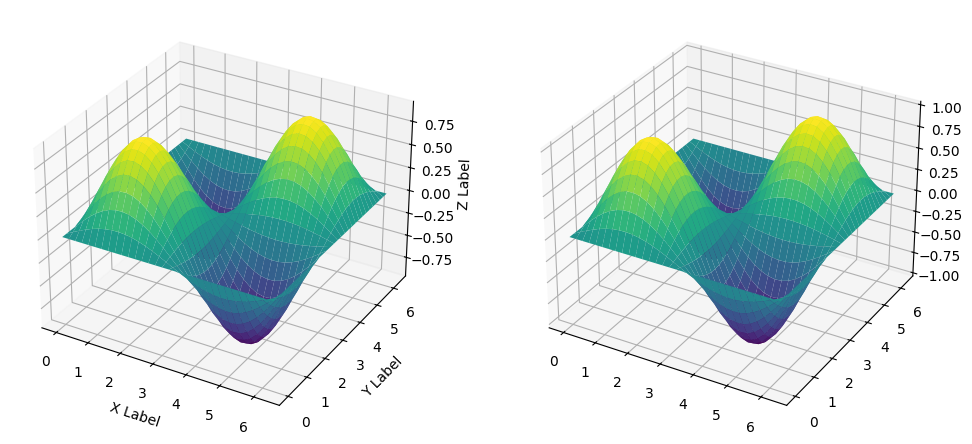

In [349]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# %matplotlib widget




fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122,projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U(x,y)')
# Plot a 3D surface
ax.plot_surface(xplot, yplot, uplot, cmap='viridis')
ax1.plot_surface(xplot,yplot,vplot,cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U(x,y)')

plt.show()

In [350]:

ss = np.power(0.1,np.linspace(2.1,3,10))
u_exact = u(X,Y,2*np.pi)
error = []
for s in ss:

    u_approx, t_end = run_forward_method(U,X,Y,f,Lap,0,2*np.pi,s,midpoint_step)
    error.append(np.sqrt(np.sum(np.square(u_approx - u_exact)))/np.sqrt(np.sum(np.square(u_exact))))
    print(s,error[-1])


0.007943282347242814 0.0003226641361952861
0.00630957344480193 0.0002432619278403982
0.00501187233627272 0.00019402408824802277
0.003981071705534974 0.00016423047892764883
0.00316227766016838 0.00014666880334380562
0.00251188643150958 0.0001363176653044627
0.001995262314968879 0.00012997541786266594
0.0015848931924611143 0.00012617862534146322
0.0012589254117941677 0.0001238106791378793
0.0010000000000000002 0.00012235105778601432


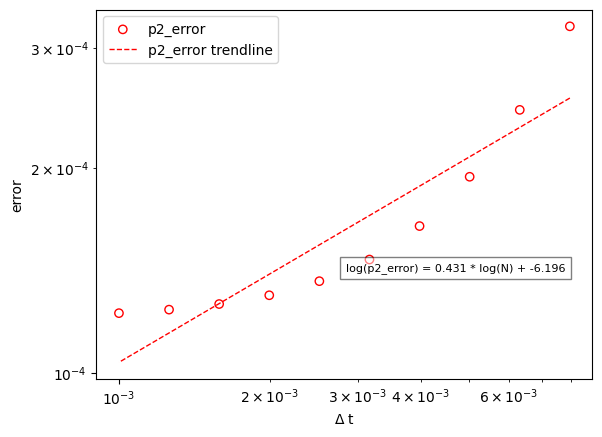

In [351]:
import matplotlib.pyplot as plt
import pandas as pd
fig,ax = plt.subplots()
# df = pd.read_csv('homework_1_problem_2_error.csv')
p2_error = error
nn =  ss
# nn = ss
# nn=np.pi*2/nn
ax.scatter(nn, p2_error, facecolor='none', edgecolors='red', label="p2_error")
# ax.scatter(nn, p2_error_ib, facecolor='none', edgecolors='blue', label="p2_error (ib included)")

tlp2 = np.polyfit(np.log(nn), np.log(p2_error), 1)
# tlp2ib = np.polyfit(np.log(nn), np.log(p2_error_ib), 1)

p2_trend = np.dot(np.array(tlp2).reshape(1,-1),np.array([np.log(nn),np.ones(len(nn))])).flatten()
# p2ib_trend = np.dot(np.array(tlp2ib).reshape(1,-1),np.array([np.log(nn),np.ones(len(nn))])).flatten()

ax.plot(nn, np.exp(p2_trend), 'red', linewidth=1, linestyle = 'dashed',label="p2_error trendline")
# ax.plot(nn, np.exp(p2ib_trend), 'blue', linewidth=1, linestyle = 'dashed',label="p2_error trendline (ib included)")

# print(f'slope p2 = {tlp2[0]} slope p2 = {tlp2ib[0]}')

equation = "".join([f"log(p2_error) = {round(tlp2[0],3)} * log(N) + {round(tlp2[1],3)}"])

plt.text(np.median(nn),np.median(p2_error), equation, fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta$ t')
ax.set_ylabel('error')
ax.legend()

In [352]:
ss = np.power(0.1,np.linspace(1,2,10))
u_exact = u(X,Y,2*np.pi)
error = []
for s in ss:
    u_approx, t_end = run_forward_method(U,X,Y,f,Lap,0,2*np.pi,s,backward_euler_step)
    error.append(np.sqrt(np.sum(np.square(u_approx - u_exact)))/np.sqrt(np.sum(np.square(u_exact))))

In [353]:
def search_t(method,err,tol):
    i = 100
    step = .1
    step_scale = step*.5
    diff = 1
    while i < 1000:
        u_approx, t_end = run_forward_method(U,X,Y,f,Lap,0,2*np.pi,step,method)
        error = np.sqrt(np.sum(np.square(u_approx - u_exact)))/np.sqrt(np.sum(np.square(u_exact)))
        if err > error:
            if step_scale*.1 < tol:
                break
            step +=step_scale*.1
        else: 
            step -= step_scale
            step_scale = step*.3

    return step 

In [364]:
s = .00003
u_approx, t_end = run_forward_method(U,X,Y,f,Lap,0,2*np.pi,s,forward_euler_step)
np.sqrt(np.sum(np.square(u_approx - u_exact)))/np.sqrt(np.sum(np.square(u_exact)))

0.00014099542256675637

In [ ]:
s = .0001
u_approx, t_end = run_forward_method(U,X,Y,f,Lap,0,2*np.pi,s,backward_euler_step)
np.sqrt(np.sum(np.square(u_approx - u_exact)))/np.sqrt(np.sum(np.square(u_exact)))